In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from IPython.core.display import display, HTML

In [2]:
train_list_filenames=[]
train_list_labels=[]
dstpath='../input/covidx-cxr2/train'
test_df = pd.read_csv('../input/covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())
train_txt= open("../input/covidx-cxr2/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(dstpath, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)

                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0          ../input/covidx-cxr2/train/ARDSSevere.png  negative
1  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
2  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
3  ../input/covidx-cxr2/train/ards-secondary-to-t...  negative
4  ../input/covidx-cxr2/train/pneumocystis-pneumo...  negative
positive    15994
negative    13992
Name: labels, dtype: int64


In [3]:
file_count = 5000
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

positive    5000
negative    5000
Name: labels, dtype: int64
10000


In [4]:
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)
print('Initial train and test split')
#print(valid_df['labels'].ravel())
print(len(valid_df))
height=224
width=224
channels=3
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.9
train_df, valid_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
print('head of validation dataframe:', valid_df.head())
#print(valid_df['labels'].ravel())
print('debug point')
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
print('image size')
print(img_size)
train_gen=gen.flow_from_dataframe( train_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
length= len(test_df) # determine test batch size and test steps such that test_batch_size X test_steps = number of test samples
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  
test_steps=int(length/test_batch_size) 
test_gen=gen.flow_from_dataframe( test_df, '../input/covidx-cxr2/test', x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
train_steps=int(len(train_gen.labels)/batch_size)

Initial train and test split
1000
head of validation dataframe:                                               filenames    labels
2656  ../input/covidx-cxr2/train/46342bb0-4583-455a-...  negative
445   ../input/covidx-cxr2/train/6bde463a-d52c-4730-...  negative
9505  ../input/covidx-cxr2/train/b8a8cb09-03d8-4748-...  negative
332   ../input/covidx-cxr2/train/63ef9b68-0489-48bf-...  negative
4168  ../input/covidx-cxr2/train/A143943-01-05-1901-...  positive
debug point
train samples:  9000   test samples:  400  validation samples 1000
image size
(224, 224)
Found 9000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [5]:
true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
test_image_ids = os.listdir('../input/covidx-cxr2/test/')
print('VALID GEN', valid_gen.class_indices)
print(len(test_image_ids))
print(test_df)
i=0
for image_id in test_image_ids[:int(len(test_image_ids))]:
    path = os.path.join('../input/covidx-cxr2/test/',image_id)
    true_value.append(valid_gen.class_indices[test_df['labels'][i]])
    img = cv2.resize(cv2.imread(path),(224,224))
    img_normalized = img/255
    i += 1

VALID GEN {'negative': 0, 'positive': 1}
400
                                     filenames    labels
0    MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1    MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2    MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3    MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4    MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
..                                         ...       ...
395   a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png  negative
396   41bf2042-53a2-44a8-9a29-55e643af5ac0.png  negative
397   ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png  negative
398   abff4044-3c0a-458f-b0c7-04254be7fc0c.png  negative
399   27b32500-40ef-4c14-ab88-ace5e9ceea27.png  negative

[400 rows x 2 columns]


# **Building ensemble using prediction results from VGG-16, Resnet-50 and InceptionV3**

In [6]:
import numpy as np
CSVData = open("../input/predarrays/resnetarr.txt")
resnet_arr = np.loadtxt(CSVData, delimiter=",")
CSVData = open("../input/vggarray/vgg3.txt")
vgg_arr = np.loadtxt(CSVData, delimiter=",")
CSVData = open("../input/predarrays/inceptionarr.txt")
inception_arr = np.loadtxt(CSVData, delimiter=",")
CSVData = open("../input/xceptionpred/xception-pred.txt")
xception_arr = np.loadtxt(CSVData)
xception_arr = [[i, 1-i] for i in xception_arr]
xception_arr = xception_arr + ([[0.997774632, 1-0.997774632]])
CSVData = open("../input/efficientnetpred/efficientNet-pred")
effnet_arr = np.loadtxt(CSVData)
effnet_arr = [[i, 1-i] for i in effnet_arr]
print(len(xception_arr))
print(len(effnet_arr))


vgg_pred = []
resnet_pred = []
inception_pred = []

vgg_acc = 0.9675
resnet_acc = 0.9325
inception_acc = 0.94

print(np.shape(resnet_arr))
print(np.shape(vgg_arr))
print(np.shape(inception_arr))
majority_vote_pred = []
mean_pred = []

for i in range(len(resnet_arr)):
    temp = []
    rpred = np.argmax(resnet_arr[i])
    ipred = np.argmax(inception_arr[i])
    vpred = np.argmax(vgg_arr[i])
    
    vgg_pred.append(vpred)
    resnet_pred.append(rpred)
    inception_pred.append(ipred)
    
    temp.append(resnet_arr[i][0]*resnet_acc + vgg_arr[i][0] * vgg_acc +inception_acc*inception_arr[i][0])
    temp.append(resnet_arr[i][1]*resnet_acc + vgg_arr[i][1] * vgg_acc +inception_acc*inception_arr[i][1])
    ssum = rpred + ipred + vpred
    if(ssum>=2):
        majority_vote_pred.append(1)
    else:
        majority_vote_pred.append(0)
    
    mean_pred.append(np.argmax(temp))

print(len(resnet_arr))

400
400
(400, 2)
(400, 2)
(400, 2)
400


In [7]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def classification_report(true_value, model_pred):
    classes = valid_gen.class_indices.keys()
    print(classes)
    print(len(true_value))
    print(len(model_pred))
    TP_count = []
    i=0
    for i in range(len(true_value)):   
        val = (true_value[i] == model_pred[i])
        TP_count.append(val)
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    return model_accuracy

# **Code for classification reports for Weighted Mean and Majority Vote ensemble models**

dict_keys(['negative', 'positive'])
400
400
Model Accuracy 0.965
dict_keys(['negative', 'positive'])
400
400
Model Accuracy 0.9675


0.9675

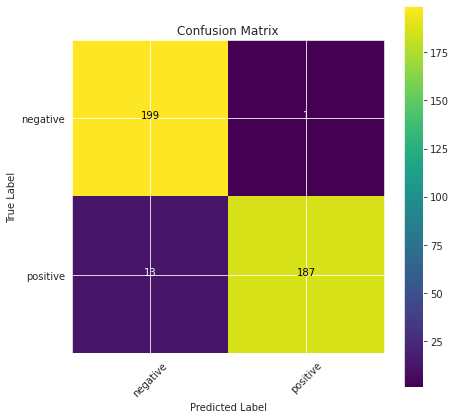

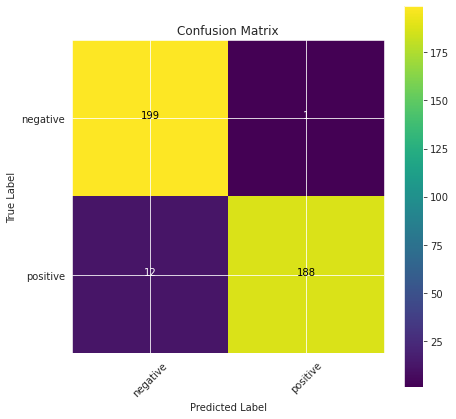

In [8]:
classification_report(true_value, mean_pred)
classification_report(true_value, majority_vote_pred)

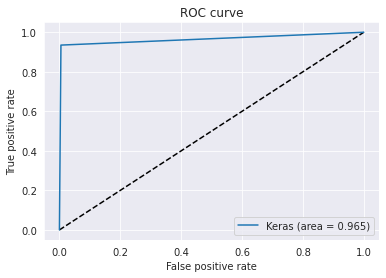

0.965


In [9]:
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.labels, mean_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print(auc_keras)

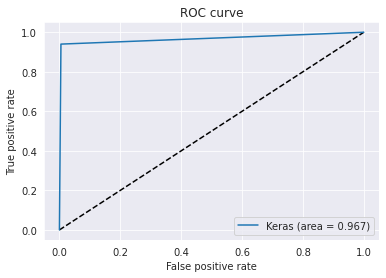

0.9674999999999999


In [10]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.labels, majority_vote_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print(auc_keras)

***Following is the code for extracting examples for Easy, Average and Hard cases***

# **Examples predictions for Inception**

178


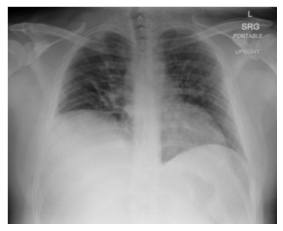

0.999888062


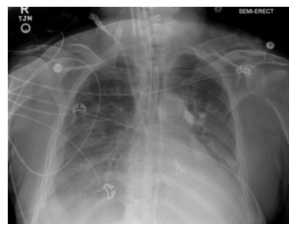

0.996864259


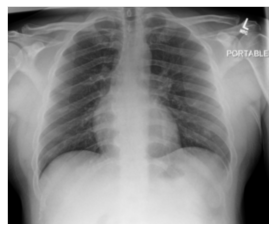

0.788906097
22


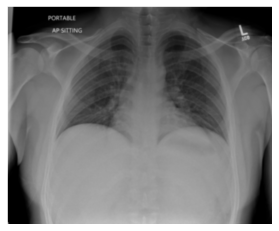

0.00428501097


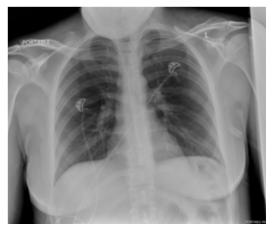

0.00498018553


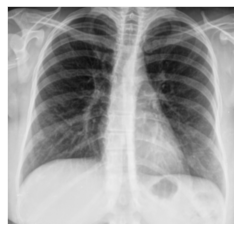

0.0198139288
200


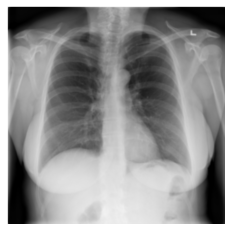

0.999969959


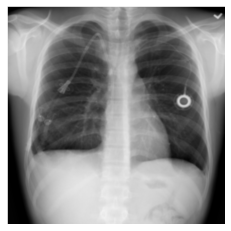

0.999985099


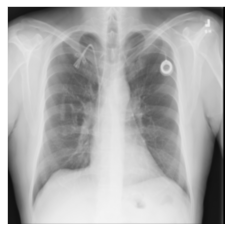

0.999987602


In [11]:
import cv2
true_pos = [(test_df.filenames[i], inception_arr[i][1])  for i in range(len(inception_arr)) if inception_arr[i][1] >  inception_arr[i][0] and test_df.labels[i] == 'positive']
print(len(true_pos))
for i in range(3):
    path = '../input/covidx-cxr2/test/'+true_pos[i][0]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(true_pos[i][1])


false_pos = [(test_df.filenames[i], inception_arr[i][1]) for i in range(len(inception_arr)) if inception_arr[i][1] <  inception_arr[i][0] and test_df.labels[i] == 'positive']
print(len(false_pos))
for i in range(3):
    path = '../input/covidx-cxr2/test/'+false_pos[i][0]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(false_pos[i][1])


true_neg = [(test_df.filenames[i], inception_arr[i][0]) for i in range(len(inception_arr)) if inception_arr[i][1] <  inception_arr[i][0] and test_df.labels[i] == 'negative']
print(len(true_neg))
for i in range(3):
    path = '../input/covidx-cxr2/test/'+true_neg[i][0]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(true_neg[i][1])

# **Easy case examples**

4


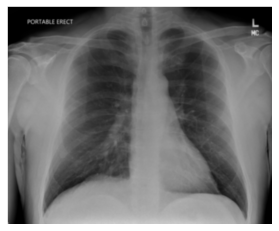

('MIDRC-RICORD-1C-419639-003334-51353-0.png', 0.767511964, 0.97075361, 0.98641324, 0.9935015, 0.83073346)


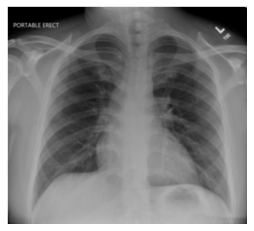

('MIDRC-RICORD-1C-419639-003157-67493-0.png', 0.94617033, 0.991023421, 0.986656308, 0.9902383, 0.76507562)


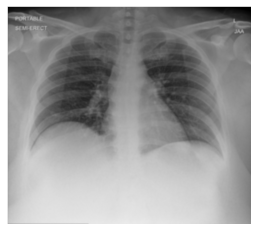

('MIDRC-RICORD-1C-419639-002733-79941-0.png', 0.998676836, 0.999111593, 0.980602503, 0.9960549, 0.6029253)
2


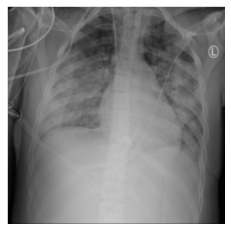

('4dbc44ca-694a-4814-9a24-bc60c8d8d611.png', 0.847890735, 0.937935472, 0.938971519, 0.84022671, 0.8489604)


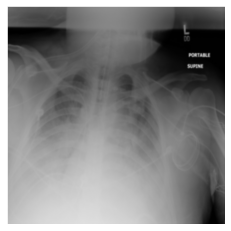

('3186d210-966f-4733-ba72-98729be9551a.png', 0.999997377, 0.998295248, 0.971722364, 0.985071781, 0.7131052)


In [16]:
#Easy case
true_pos = [(test_df.filenames[i], inception_arr[i][1], vgg_arr[i][1], resnet_arr[i][1], xception_arr[i][1], effnet_arr[i][1])  for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and xception_arr[i][1]>xception_arr[i][0] and effnet_arr[i][1]>effnet_arr[i][0] and test_df.labels[i] == 'positive')]
print(len(true_pos))
path = '../input/covidx-cxr2/test/'+true_pos[0][0]
img = cv2.imread(path)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(true_pos[0])

path = '../input/covidx-cxr2/test/'+true_pos[1][0]
img = cv2.imread(path)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(true_pos[1])

path = '../input/covidx-cxr2/test/'+true_pos[2][0]
img = cv2.imread(path)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(true_pos[2])



true_neg = [(test_df.filenames[i], inception_arr[i][0], vgg_arr[i][0], resnet_arr[i][0], xception_arr[i][0], effnet_arr[i][0])  for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and xception_arr[i][1]<xception_arr[i][0] and effnet_arr[i][1]<effnet_arr[i][0] and test_df.labels[i] == 'negative')]
print(len(true_neg))
path = '../input/covidx-cxr2/test/'+true_neg[0][0]
img = cv2.imread(path)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(true_neg[0])

path = '../input/covidx-cxr2/test/'+true_neg[1][0]
img = cv2.imread(path)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(true_neg[1])

# **Average Case Examples**

16


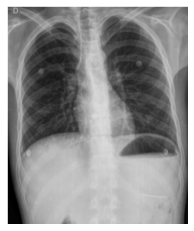

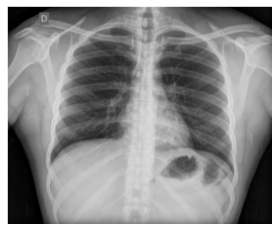

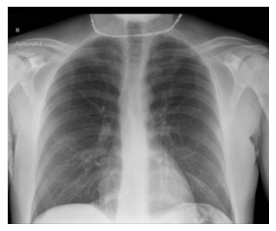

8


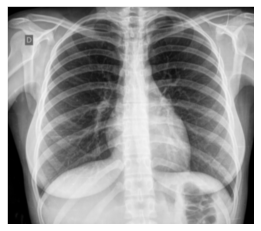

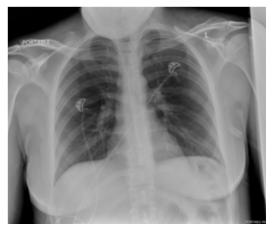

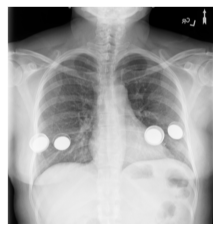

2


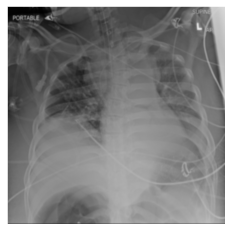

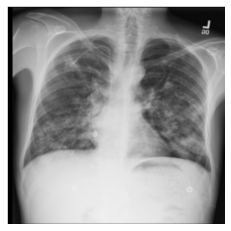

1


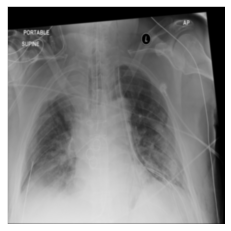

In [15]:
#Average case examples
import cv2
twoConeINC = [] 
twoConeINC1 = [] 
twoConeINC2 = [] 
twoConeINC3 = [] 
#actual positive, 2 predicted positive and one predicted negative
twoConeINC1 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and test_df.labels[i] == 'positive')]
twoConeINC2 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and test_df.labels[i] == 'positive')]
twoConeINC3 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and test_df.labels[i] == 'positive')]

twoConeINC = twoConeINC1 + twoConeINC2 + twoConeINC1
print(len(twoConeINC))
for i in range(3):
    path = '../input/covidx-cxr2/test/'+twoConeINC[i]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

#actual positive, 1 predicted positive and 2 predicted negative
oneCtwoINC = []
oneCtwoINC1 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and test_df.labels[i] == 'positive')]
oneCtwoINC2 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and test_df.labels[i] == 'positive')]
oneCtwoINC3 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and test_df.labels[i] == 'positive')]
oneCtwoINC = oneCtwoINC1 + oneCtwoINC2 + oneCtwoINC3
print(len(oneCtwoINC))
for i in range(3):
    path = '../input/covidx-cxr2/test/'+oneCtwoINC[i]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()


#actual negative, 2 predicted negative and one predicted positive
twoConeINC = []
twoConeINC1 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and test_df.labels[i] == 'negative')]
twoConeINC2 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and test_df.labels[i] == 'negative')]
twoConeINC3 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and test_df.labels[i] == 'negative')]
twoConeINC = twoConeINC1 + twoConeINC2 + twoConeINC3
print(len(twoConeINC))
for i in range(2):
    path = '../input/covidx-cxr2/test/'+twoConeINC[i]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

#actual negative, 1 predicted negative and 2 predicted positive
oneCtwoINC = []
oneCtwoINC1 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and test_df.labels[i] == 'negative')]
oneCtwoINC2 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and test_df.labels[i] == 'negative')]
oneCtwoINC3 = [test_df.filenames[i] for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and test_df.labels[i] == 'negative')]
oneCtwoINC = oneCtwoINC1 + oneCtwoINC2 + oneCtwoINC3
print(len(oneCtwoINC))
for i in range(1):
    path = '../input/covidx-cxr2/test/'+oneCtwoINC[i]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

# **Hard case Examples**

0
4


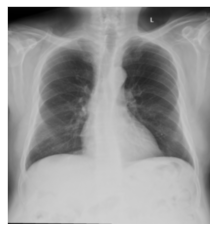

('MIDRC-RICORD-1C-419639-002784-76664-0.png', 0.00190064334, 0.309123367, 0.113471135, 0.9974675, 0.92704265)


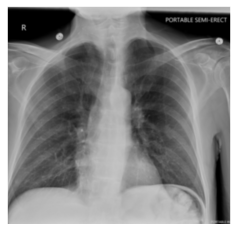

('MIDRC-RICORD-1C-419639-000582-21506-0.png', 0.00114337227, 0.248925984, 0.202131107, 0.99577314, 0.14184695000000003)


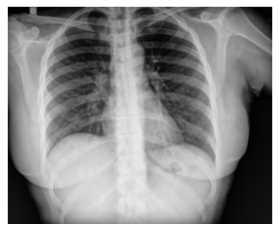

('MIDRC-RICORD-1C-SITE2-000149-71428-1.png', 0.152563304, 0.186050326, 0.43686974, 0.0002026200000000422, 0.7247074)


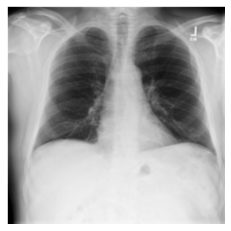

('MIDRC-RICORD-1C-419639-002895-42704-0.png', 0.000988741405, 0.0491776802, 0.248643711, 2.2199999999972242e-05, 0.93709042)


In [20]:
#Hard case
false_pos = [(test_df.filenames[i], inception_arr[i][0], vgg_arr[i][0], resnet_arr[i][0], xception_arr[i][0], effnet_arr[i][0])  for i in range(len(inception_arr)) if (inception_arr[i][1]>inception_arr[i][0] and resnet_arr[i][1]>resnet_arr[i][0] and vgg_arr[i][1]>vgg_arr[i][0] and test_df.labels[i] == 'negative')]
print(len(false_pos))
for i in range(len(false_pos)):
    path = '../input/covidx-cxr2/test/'+true_neg[i][0]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(false_pos[i])


false_neg = [(test_df.filenames[i], inception_arr[i][1], vgg_arr[i][1], resnet_arr[i][1], xception_arr[i][1], effnet_arr[i][1])  for i in range(len(inception_arr)) if (inception_arr[i][1]<inception_arr[i][0] and resnet_arr[i][1]<resnet_arr[i][0] and vgg_arr[i][1]<vgg_arr[i][0] and test_df.labels[i] == 'positive')]
print(len(false_neg))
for i in range(len(false_neg)):
    path = '../input/covidx-cxr2/test/'+false_neg[i][0]
    img = cv2.imread(path)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(false_neg[i])